In [1]:
'''
Deploy SqueezeNet, requires 'squeezenet_architecture.py'

Train and evaluate against the CIFAR-10 dataset avaliable in tensorflow. Code adapted from the paper 'SqueezeNet :
AlexNet-Level Accuracy with 50x fewer parameters and <0.5MB model size' by: Iandola et al.

'''

# import libraries

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%run squeezenet_architecture.ipynb # get fire_mod and SqueezeNet from other notebook

# shortcut to modules provided in tf
datasets = tf.keras.datasets
layers =  tf.keras.layers
models = tf.keras.models
losses = tf.keras.losses
optimizers = tf.keras.optimizers 
metrics = tf.keras.metrics
preprocessing_image = tf.keras.preprocessing.image
utils = tf.keras.utils
callbacks = tf.keras.callbacks

In [2]:
# Load the CIFAR-10 dataset through tf
# Note : could take a few minutes depending on machine...

(x_train, y_train), (x_test, y_test)= datasets.cifar10.load_data()


170500096/170498071 [==============================] - 75s 0us/step


In [3]:
# one hot encode the target

y_train = utils.to_categorical(y_train, num_classes = 10)
y_test = utils.to_categorical(y_test, num_classes = 10)

# preprocessing with ImageDataGenerator (training data generator has additional augumentation steps, the test only has rescale)

train_data_gen = preprocessing_image.ImageDataGenerator(
    rescale = 1/255,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip=True)

test_data_gen = preprocessing_image.ImageDataGenerator(rescale = 1/255)

# create a data generator to feed the network

train_generator = train_data_gen.flow(x = x_train, y = y_train, batch_size = 32, shuffle = True) # 32 images at a time
test_generator = train_data_gen.flow(x = x_test, y = y_test, batch_size = 32, shuffle = True)

In [4]:
# Compile model (add loss, optimizer, etc)

def compile_squeeze(model):
    
    # loss - multi class (10) classification problem ~ crossentropy
    
    loss = losses.categorical_crossentropy
    
    # optimizer
    # paper used a lr of 0.04, but I am not sure which optimizer they used
    # I used ADAM optimizer with a lr = 0.001, which is typically a good 'starting point'
    
    optimizer = optimizers.Adam(lr=0.001)
                                          
    # metrics - categorical accuracy
    
    metric = [metrics.categorical_accuracy]
    
    # compile model with loss, optimizer, and evaluation metrics
    
    model.compile(optimizer, loss, metric)
    
    return model

In [5]:
# compile the model

squeezeNet = SqueezeNet()
squeezeNet = compile_squeeze(squeezeNet)

In [6]:
training = squeezeNet.fit_generator(
    train_generator,
    steps_per_epoch = 400,
    epochs = 250,
    validation_data = test_generator,
    validation_steps = 200)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 200 steps
Epoch 1/250
400/400 [==============================] - 12s 30ms/step - loss: 2.1276 - categorical_accuracy: 0.1793 - val_loss: 1.8891 - val_categorical_accuracy: 0.2600
Epoch 2/250
400/400 [==============================] - 12s 29ms/step - loss: 1.8581 - categorical_accuracy: 0.2841 - val_loss: 1.7459 - val_categorical_accuracy: 0.3514
Epoch 3/250
400/400 [==============================] - 12s 29ms/step - loss: 1.7359 - categorical_accuracy: 0.3445 - val_loss: 1.6777 - val_categorical_accuracy: 0.3664
Epoch 4/250
400/400 [==============================] - 12s 29ms/step - loss: 1.6290 - categorical_accuracy: 0.3883 - val_loss: 1.6327 - val_categorical_accuracy: 0.3894
Epoch 5/250
400/400 [==============================] - 12s 29ms/step - loss: 1.5851 - categorical_accuracy: 0.4098 - val_loss: 1.5112 - val_categorical_ac

400/400 [==============================] - 12s 29ms/step - loss: 0.9448 - categorical_accuracy: 0.6660 - val_loss: 0.9894 - val_categorical_accuracy: 0.6511
Epoch 47/250
400/400 [==============================] - 12s 29ms/step - loss: 0.9658 - categorical_accuracy: 0.6577 - val_loss: 0.9702 - val_categorical_accuracy: 0.6533
Epoch 48/250
400/400 [==============================] - 12s 29ms/step - loss: 0.9462 - categorical_accuracy: 0.6655 - val_loss: 0.9637 - val_categorical_accuracy: 0.6648
Epoch 49/250
400/400 [==============================] - 12s 29ms/step - loss: 0.9302 - categorical_accuracy: 0.6752 - val_loss: 0.9891 - val_categorical_accuracy: 0.6519
Epoch 50/250
400/400 [==============================] - 12s 29ms/step - loss: 0.9399 - categorical_accuracy: 0.6688 - val_loss: 0.9292 - val_categorical_accuracy: 0.6762
Epoch 51/250
400/400 [==============================] - 11s 29ms/step - loss: 0.9288 - categorical_accuracy: 0.6756 - val_loss: 1.0082 - val_categorical_accuracy: 

400/400 [==============================] - 12s 29ms/step - loss: 0.7407 - categorical_accuracy: 0.7462 - val_loss: 0.8398 - val_categorical_accuracy: 0.7047
Epoch 95/250
400/400 [==============================] - 12s 29ms/step - loss: 0.7454 - categorical_accuracy: 0.7378 - val_loss: 0.7781 - val_categorical_accuracy: 0.7284
Epoch 96/250
400/400 [==============================] - 12s 29ms/step - loss: 0.7498 - categorical_accuracy: 0.7349 - val_loss: 0.7949 - val_categorical_accuracy: 0.7294
Epoch 97/250
400/400 [==============================] - 12s 29ms/step - loss: 0.7391 - categorical_accuracy: 0.7382 - val_loss: 0.8303 - val_categorical_accuracy: 0.7125
Epoch 98/250
400/400 [==============================] - 12s 29ms/step - loss: 0.7557 - categorical_accuracy: 0.7354 - val_loss: 0.7937 - val_categorical_accuracy: 0.7247
Epoch 99/250
400/400 [==============================] - 12s 30ms/step - loss: 0.7303 - categorical_accuracy: 0.7472 - val_loss: 0.7902 - val_categorical_accuracy: 

400/400 [==============================] - 12s 29ms/step - loss: 0.6759 - categorical_accuracy: 0.7638 - val_loss: 0.7476 - val_categorical_accuracy: 0.7450
Epoch 143/250
400/400 [==============================] - 12s 29ms/step - loss: 0.6634 - categorical_accuracy: 0.7659 - val_loss: 0.7762 - val_categorical_accuracy: 0.7380
Epoch 144/250
400/400 [==============================] - 11s 29ms/step - loss: 0.6581 - categorical_accuracy: 0.7695 - val_loss: 0.7642 - val_categorical_accuracy: 0.7358
Epoch 145/250
400/400 [==============================] - 12s 29ms/step - loss: 0.6659 - categorical_accuracy: 0.7664 - val_loss: 0.7530 - val_categorical_accuracy: 0.7384
Epoch 146/250
400/400 [==============================] - 12s 29ms/step - loss: 0.6678 - categorical_accuracy: 0.7686 - val_loss: 0.7426 - val_categorical_accuracy: 0.7453
Epoch 147/250
400/400 [==============================] - 12s 29ms/step - loss: 0.6729 - categorical_accuracy: 0.7620 - val_loss: 0.7559 - val_categorical_accur

Epoch 190/250
400/400 [==============================] - 12s 29ms/step - loss: 0.6228 - categorical_accuracy: 0.7795 - val_loss: 0.7305 - val_categorical_accuracy: 0.7531
Epoch 191/250
400/400 [==============================] - 12s 29ms/step - loss: 0.6283 - categorical_accuracy: 0.7779 - val_loss: 0.7420 - val_categorical_accuracy: 0.7487
Epoch 192/250
400/400 [==============================] - 12s 29ms/step - loss: 0.6241 - categorical_accuracy: 0.7818 - val_loss: 0.7270 - val_categorical_accuracy: 0.7477
Epoch 193/250
400/400 [==============================] - 12s 29ms/step - loss: 0.6248 - categorical_accuracy: 0.7806 - val_loss: 0.7426 - val_categorical_accuracy: 0.7450
Epoch 194/250
400/400 [==============================] - 11s 29ms/step - loss: 0.6146 - categorical_accuracy: 0.7859 - val_loss: 0.7465 - val_categorical_accuracy: 0.7498
Epoch 195/250
400/400 [==============================] - 11s 28ms/step - loss: 0.6243 - categorical_accuracy: 0.7744 - val_loss: 0.7397 - val_cat

Epoch 238/250
400/400 [==============================] - 12s 29ms/step - loss: 0.5943 - categorical_accuracy: 0.7938 - val_loss: 0.7199 - val_categorical_accuracy: 0.7620
Epoch 239/250
400/400 [==============================] - 12s 30ms/step - loss: 0.5819 - categorical_accuracy: 0.7955 - val_loss: 0.6951 - val_categorical_accuracy: 0.7664
Epoch 240/250
400/400 [==============================] - 12s 29ms/step - loss: 0.5880 - categorical_accuracy: 0.7923 - val_loss: 0.7267 - val_categorical_accuracy: 0.7567
Epoch 241/250
400/400 [==============================] - 11s 29ms/step - loss: 0.5811 - categorical_accuracy: 0.7963 - val_loss: 0.7497 - val_categorical_accuracy: 0.7456
Epoch 242/250
400/400 [==============================] - 12s 29ms/step - loss: 0.5892 - categorical_accuracy: 0.7927 - val_loss: 0.7847 - val_categorical_accuracy: 0.7372
Epoch 243/250
400/400 [==============================] - 12s 29ms/step - loss: 0.5988 - categorical_accuracy: 0.7912 - val_loss: 0.7382 - val_cat

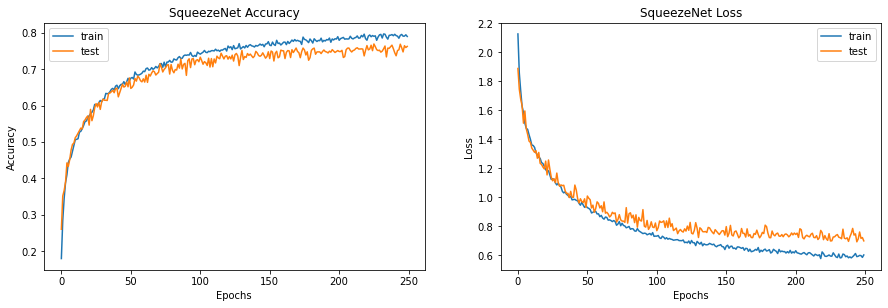

In [7]:
def plot_accuracy_and_loss(training):
    plt.figure(1, figsize= (15, 10))
    
    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(training.history['categorical_accuracy'])
    plt.plot(training.history['val_categorical_accuracy'])
    plt.title('SqueezeNet Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(training.history['loss'])
    plt.plot(training.history['val_loss'])
    plt.title('SqueezeNet Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'test'], loc='upper right')
    
    plt.show()
    
plot_accuracy_and_loss(training)

In [8]:
# save model architecture
model_json = squeezeNet.to_json()
open('models/squeeze_net.json', 'w').write(model_json)

# save model's learned weights
squeezeNet.save_weights('models/squeeze_net.h5', overwrite=True)